In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array
import matplotlib.pyplot as plt
import seaborn as sns
from MultiSeriesWindowsGenerator import MultiSeriesWindowsGenerator

2023-04-10 17:51:35.053283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
pd.set_option("display.max_row", 40)

In [4]:
data_list = []
for i in range(0, 27):
    df = pd.read_csv(f"data/aggregated_individual_data_interpolation/interpolation/{i}_interpolated.csv", index_col=0)
    df["subject_id"] = i+1
    data_list.append(df)

# Concatenate the data into a single dataset
data = pd.concat(data_list)
data.drop(["circumplex.arousal_std","circumplex.valence_std","mood_std","activity_std"], inplace=True,axis=1)
# date_time = pd.to_datetime(df.pop('date'))
# df['days'] = date_time
# df = data

In [5]:
use_date = 0

if use_date:
    data.drop(["date"], inplace=True,axis=1)
    date_time = pd.to_datetime(data.pop('date'))
    df = data
    df['days'] = date_time

else: # use days from day 0 of recording
    data.drop(["date"], inplace=True,axis=1)
    df = data

df.reset_index(inplace=True,drop=True)
df = df.astype({'subject_id': 'float64','days': 'float64','weekday': 'float64'})

In [6]:
df = data
df.reset_index(inplace=True,drop=True)
df = df.astype({'subject_id': 'float64','days': 'float64','weekday': 'float64'})

In [38]:
LABELS = ['mood']
REGRESSORS = ['weekday', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

DATE = 'days' # always correct
IN_STEPS = 7 # use 7 days
OUT_STEPS = 7 # to predict 1 day in the future
GROUPBY = ['subject_id']
BATCH_SIZE = 8

In [39]:
n = len(df)
train_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(lambda x: x.iloc[:int(len(x) * 0.7)]).reset_index(drop=True)
val_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(lambda x: x.iloc[int(len(x) * 0.7):int(len(x) * 0.9)]).reset_index(drop=True)
test_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(lambda x: x.iloc[int(len(x) * 0.9):]).reset_index(drop=True)
train_series.shape, val_series.shape, test_series.shape

((804, 22), (234, 22), (130, 22))

# Baseline Model

In [46]:
cur_window = MultiSeriesWindowsGenerator(
    input_width=IN_STEPS, label_width=OUT_STEPS, shift=1, batch_size=BATCH_SIZE, GROUPBY=GROUPBY, label_columns=LABELS, regressor_columns=REGRESSORS, DATE=DATE, LABELS=LABELS)
cur_window.update_datasets(train_series, val_series, test_series, norm=True)

In [47]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [48]:
baseline = Baseline(label_index=cur_window.column_indices[LABELS[0]])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(cur_window.val)
performance['Baseline'] = baseline.evaluate(cur_window.test, verbose=0)

75/75 [==============================] - 2s 2ms/step - loss: 0.7553 - mean_absolute_error: 0.3386


In [49]:
def plot_2(self, model=None, plot_col=None, max_subplots=3):
    inputs, labels = self.example
    if not plot_col:
        plot_col = self.LABELS[0]
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))

    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f'{plot_col} {"[normed]" if self.norm else ""}')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            print(self.label_indices, predictions[n, :, label_col_index])
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [Days]')
    plt.show()

Number of train batches: 108


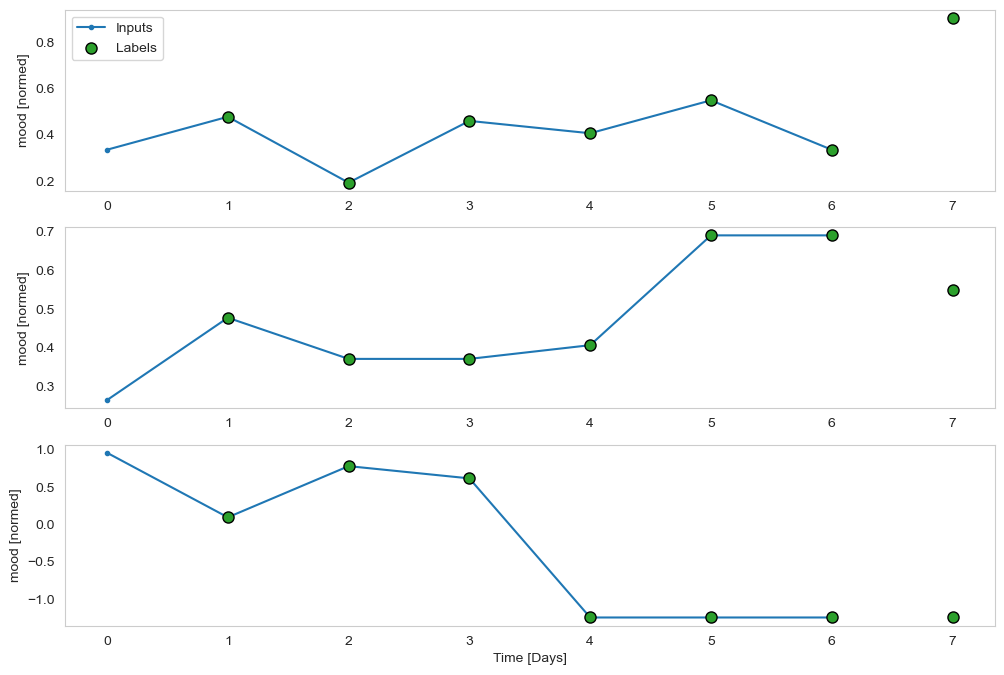

In [50]:
plot_2(cur_window)

Number of train batches: 108
[1 2 3 4 5 6 7] tf.Tensor(
[0.3348032  0.47692373 0.19268265 0.45915866 0.40586346 0.547984
 0.3348032 ], shape=(7,), dtype=float32)


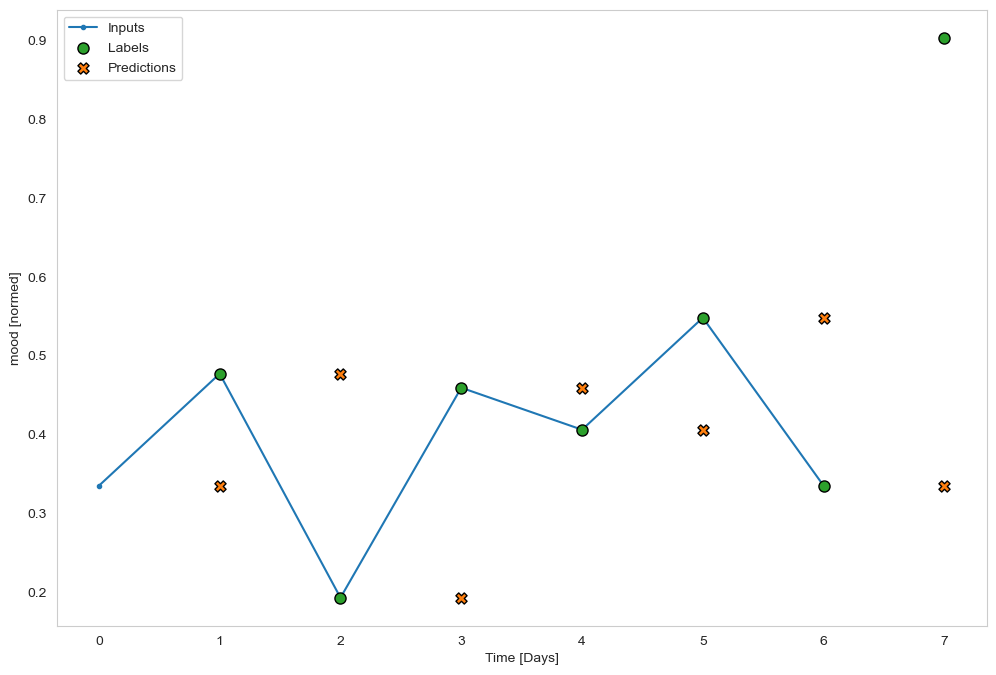

In [51]:
plot_2(cur_window,baseline, max_subplots=1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])